In [8]:
%matplotlib inline

import itertools
import os

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd
import tensorflow as tf


from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils
from sklearn.utils import class_weight
from keras import layers

In [11]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [12]:

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [13]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [19]:
df = pd.read_csv('processed_v1.csv')
df =df.dropna()

In [6]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(df.label_updated),
                                                 df.label_updated)

82368
Train on 81543 samples, validate on 9061 samples
Epoch 1/5
81543/81543 [==============================] - 10s 125us/step - loss: 1.5231 - acc: 0.4672 - precision_m: 0.6478 - recall_m: 0.2130 - f1_m: 0.3142 - val_loss: 1.4733 - val_acc: 0.4799 - val_precision_m: 0.6198 - val_recall_m: 0.2769 - val_f1_m: 0.3798
Epoch 2/5
81543/81543 [==============================] - 10s 119us/step - loss: 1.3580 - acc: 0.5172 - precision_m: 0.6895 - recall_m: 0.2960 - f1_m: 0.4103 - val_loss: 1.4790 - val_acc: 0.4825 - val_precision_m: 0.6440 - val_recall_m: 0.2662 - val_f1_m: 0.3734
Epoch 3/5
81543/81543 [==============================] - 10s 119us/step - loss: 1.1881 - acc: 0.5815 - precision_m: 0.7435 - recall_m: 0.3872 - f1_m: 0.5059 - val_loss: 1.5239 - val_acc: 0.4765 - val_precision_m: 0.5950 - val_recall_m: 0.2932 - val_f1_m: 0.3897
Epoch 4/5
81543/81543 [==============================] - 10s 119us/step - loss: 0.9612 - acc: 0.6716 - precision_m: 0.8130 - recall_m: 0.5171 - f1_m: 0.6293 - 

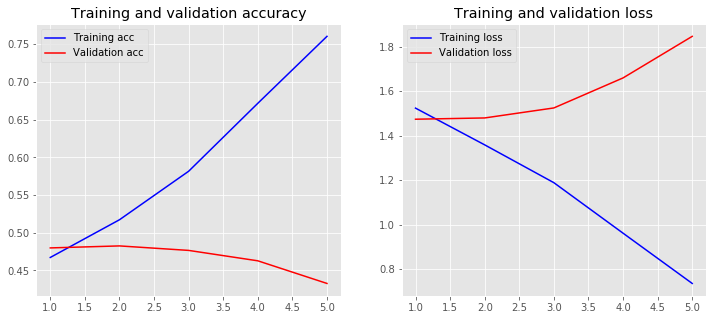

In [28]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils


x_train, x_test, y_train, y_test = train_test_split(df.cleaned_text,df.label_updated , test_size=0.20, random_state=500)
# print (y_test.unique())
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(x_train) # only fit on train

vocab_size = len(tokenize.word_index)+1 
print (vocab_size)
x_train = tokenize.texts_to_matrix(x_train)
x_test = tokenize.texts_to_matrix(x_test)

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)
# print (np.max(y_train))
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 5

# Build the model
model = Sequential()
# model.add(Dense(512, input_shape=(max_words,)))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes))
# model.add(Activation('softmax'))
# model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(512, input_shape=(max_words,), activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', precision_m, recall_m, f1_m])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    class_weight=class_weights,
                    verbose=1,
                    validation_split=0.1)
model.summary()
plot_history(history)


In [29]:
loss, accuracy, precision, recall, f1_score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
# print('Test accuracy:', score[1])
print('Test loss:', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test f1_score:', f1_score)


22652/22652 [==============================] - 1s 44us/step
Test loss: 1.8329352293885177
Test accuracy: 0.4392106657143555
Test precision: 0.509550079200749
Test recall: 0.33815998587321205
Test f1_score: 0.4049879852619858


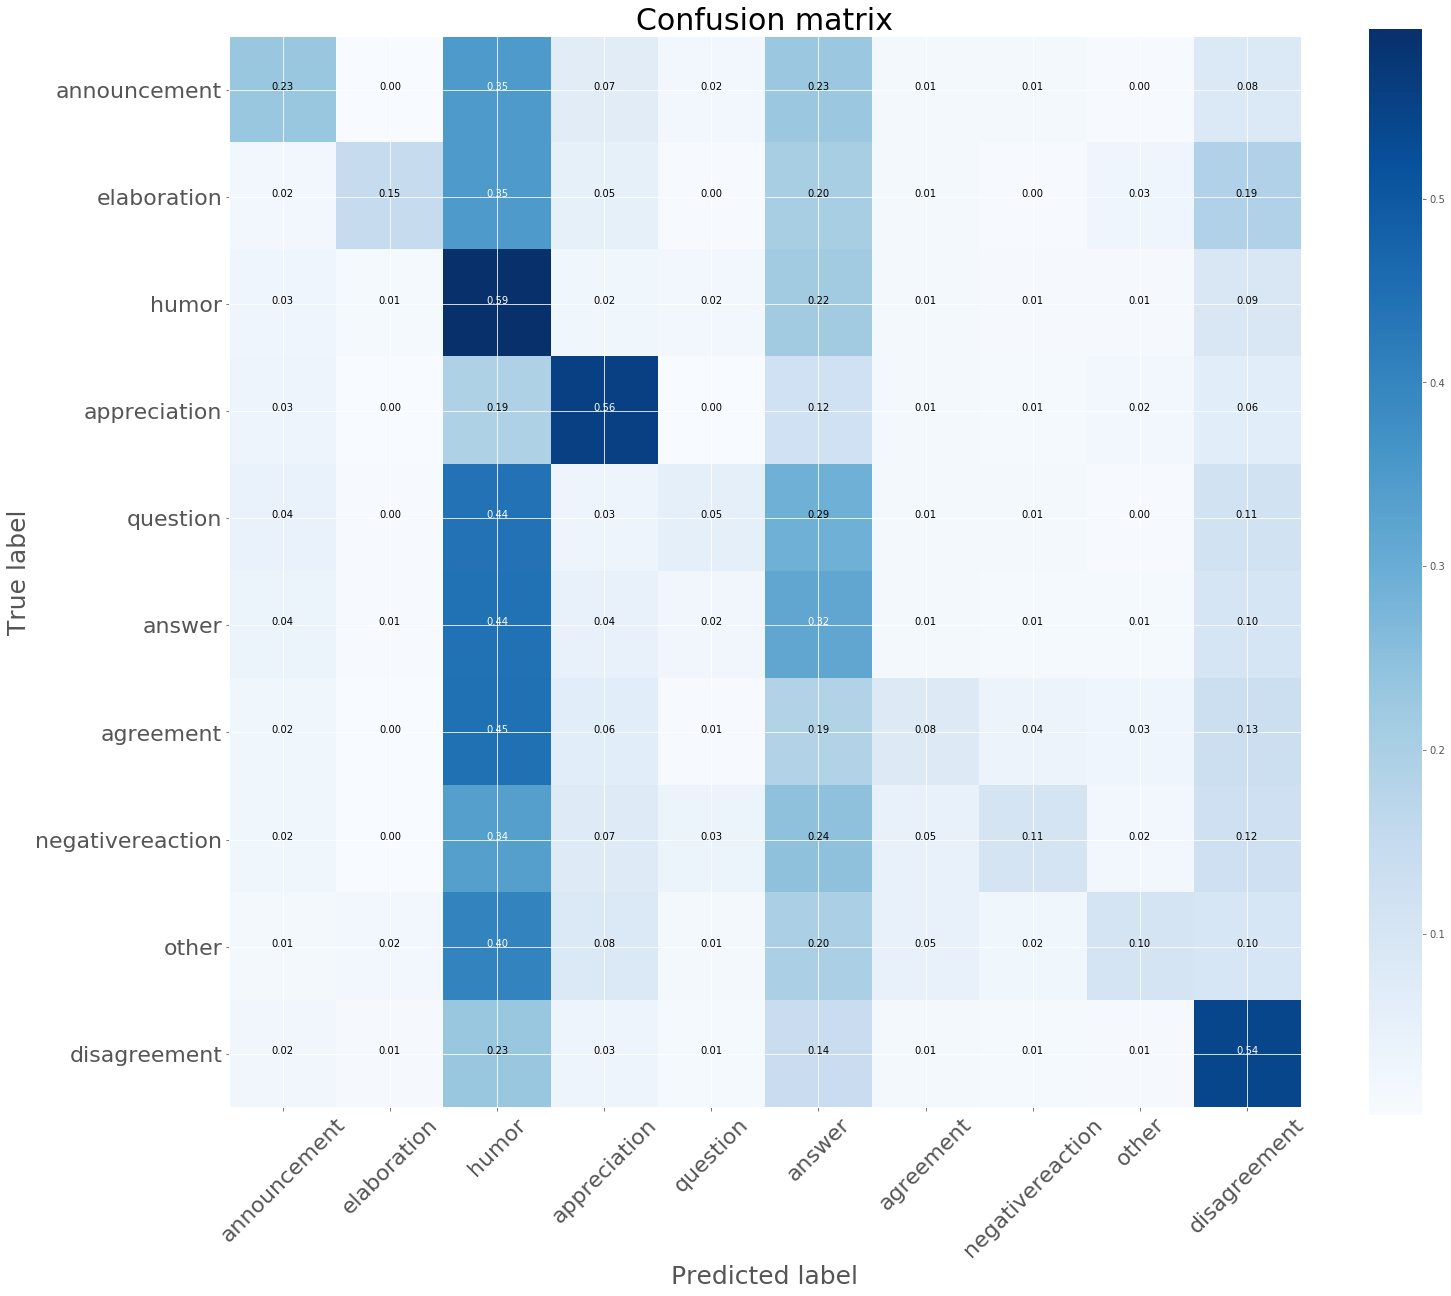

In [30]:
my_labels = ['announcement', 'elaboration', 'humor', 'appreciation', 'question',
       'answer', 'agreement', 'negativereaction', 'other', 'disagreement']

y_cm = model.predict(x_test)

y_test_cm = []
y_pred_cm = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_cm.append(one_hot_index)

for i in range(0, len(y_cm)):
    probs = y_cm[i]
    predicted_index = np.argmax(probs)
    y_pred_cm.append(predicted_index)

cnf_matrix = confusion_matrix(y_test_cm, y_pred_cm)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=my_labels, title="Confusion matrix")
plt.show()